In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import zipfile
import subprocess
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchsummary
import numpy as np
from PIL import Image
from PIL import ImageFile
import json
import cv2
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import random

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def seed_everything(seed=42):
    """
    모든 랜덤 시드를 주어진 값으로 고정합니다.
    """
    random.seed(seed)  # Python random 모듈
    np.random.seed(seed)  # Numpy 랜덤 시드
    torch.manual_seed(seed)  # PyTorch 랜덤 시드
    torch.cuda.manual_seed(seed)  # GPU를 위한 PyTorch 랜덤 시드
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 위한 PyTorch 랜덤 시드

seed_everything()

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_zip_paths, label_zip_paths, cache_dir, transform=None, workers=4):
        super().__init__()
        self.image_zip_paths = image_zip_paths
        self.label_zip_paths = label_zip_paths
        self.cache_dir = cache_dir
        self.transform = transform
        self.workers = workers

        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir, exist_ok=True)

        self.image_names = {}
        self.label_names = {}
        self.image_list = []

        self._prepare()

    def _extract_and_cache(self, zip_path, file_name, cache_file_path, attempts=3):
        if os.path.exists(cache_file_path):
            return True

        command = ["unzip", "-o", zip_path, file_name, "-d", os.path.dirname(cache_file_path)]

        for attempt in range(attempts):
            result = subprocess.run(command, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            # 성공적으로 압축 해제되었거나, 경고만 있는 경우
            if result.returncode == 0 or "warning" in result.stderr.decode().lower():
                return True
            else:
                # 오류 메시지가 있고, 재시도 횟수가 남아있는 경우
                print(f"Attempt {attempt + 1}: Error unzipping file => {zip_path}")
                time.sleep(2 ** attempt)

        # 모든 시도가 실패한 경우
        print(f"Failed to extract {file_name}")
        return False

    def _prepare(self):
        max_tries = 3
        wait_seconds = 10

        # 각 zip 파일에 대한 재시도 횟수를 추적
        retries = {zip_path: 0 for zip_path in self.image_zip_paths + self.label_zip_paths}

        # 전체 압축 파일 리스트
        to_process = [(zip_path, '.png') for zip_path in self.image_zip_paths] + [(zip_path, '.json') for zip_path in self.label_zip_paths]

        while to_process:
            # 병렬처리
            with ThreadPoolExecutor(max_workers=self.workers) as executor:
                future_to_zip_path = {
                    executor.submit(self._process_zip, zip_path, file_extension): (zip_path, file_extension)
                    for zip_path, file_extension in to_process
                }

                # 처리 중 예외 발생 시 재시도할 작업 목록
                to_retry = []

                # future 객체의 작업완료 상황을 모니터링
                for future in as_completed(future_to_zip_path):
                    zip_path, file_extension = future_to_zip_path[future]

                    try:
                        success = future.result()
                        if not success:
                            raise Exception(f"Failed to process {zip_path}")

                    except OSError as e: # 구글드라이브와의 연결로 인한 예외처리
                        if e.errno == 107 and retries[zip_path] < max_tries:
                            print(f"OSError [Errno 107] => {zip_path}")
                            to_retry.append((zip_path, file_extension))
                            retries[zip_path] += 1
                            time.sleep(wait_seconds)  # 각 재시도 사이에 대기
                            wait_seconds *= 2  # 대기 시간 증가
                        else:
                            print(f"Unexpected Error : {zip_path}: {e}")

                    except Exception as e:
                        print(f"Exception processing {zip_path}: {e}")

                # 재시도할 작업이 있으면 to_process 업데이트
                to_process = to_retry if to_retry else []

        self.image_list = sorted(self.image_names.keys())

    def _process_zip(self, zip_path, file_extension):
        success = True
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:

            for file_name in sorted(zip_ref.namelist()):

                if file_name.endswith(file_extension):
                    base_name = os.path.splitext(os.path.basename(file_name))[0].lstrip('_')  # 확장자 제외 파일 기본 이름

                    # 데이터 접근시 사용할 경로
                    cache_file_path = os.path.join(self.cache_dir, os.path.basename(zip_path).replace('.zip', ''), file_name.replace('/', '_').lstrip('_'))

                    if file_extension == '.png':
                        self.image_names[base_name.lower()] = cache_file_path
                    else:
                        self.label_names[base_name.lower()] = cache_file_path

                    extract_success = self._extract_and_cache(zip_path, file_name, cache_file_path)
                    success = success and extract_success

        return success

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # 파일 이름을 키 리스트에서 추출
        base_name = self.image_list[idx]

        image_path = self.image_names.get(base_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            return None

        label_path = self.label_names.get(base_name)
        with open(label_path, 'r') as f:
            label_data = json.load(f)

        age_past = label_data['age_past']
        gender = label_data['gender']
        box = label_data['annotation'][0]['box']

        image = image.crop((box['x'], box['y'], box['x'] + box['w'], box['y'] + box['h']))

        if self.transform:
            image = self.transform(image)

        gender_label = 0 if gender == 'male' else 1

        label = {'age_past': age_past, 'gender': gender_label}

        return image, label


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.6284, 0.4901, 0.4325), (0.1869, 0.1712, 0.1561))
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.6284, 0.4901, 0.4325), (0.1869, 0.1712, 0.1561))
])

In [ ]:
def get_zip_files(directory):
    return [os.path.join(directory, zip) for zip in os.listdir(directory) if zip.endswith('.zip')] # 리스트를 정렬하면 속도 하락

train_images = '/content/drive/MyDrive/DL_Project/data/Training/image'
train_labels = '/content/drive/MyDrive/DL_Project/data/Training/label'
train_cache = '/content/cache/train'

val_images = '/content/drive/MyDrive/DL_Project/data/Validation/image'
val_labels = '/content/drive/MyDrive/DL_Project/data/Validation/label'
val_cache = '/content/cache/val'

train_image_zips = get_zip_files(train_images)
train_label_zips = get_zip_files(train_labels)
val_image_zips = get_zip_files(val_images)
val_label_zips = get_zip_files(val_labels)

In [ ]:
train_image_zips[:3]

['/content/drive/MyDrive/DL_Project/data/Training/image/TS_0805.zip',
 '/content/drive/MyDrive/DL_Project/data/Training/image/TS_0631.zip',
 '/content/drive/MyDrive/DL_Project/data/Training/image/TS_0576.zip']

In [ ]:
%time train_dataset = CustomDataset(train_image_zips, train_label_zips, train_cache, transform_train)

CPU times: user 35.3 s, sys: 17.4 s, total: 52.8 s
Wall time: 38min 10s


In [ ]:
%time val_dataset = CustomDataset(val_image_zips, val_label_zips, val_cache, transform_val)

CPU times: user 4.37 s, sys: 2.18 s, total: 6.55 s
Wall time: 4min 31s


In [ ]:
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    collate_fn=custom_collate_fn,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    prefetch_factor=4
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    collate_fn=custom_collate_fn,
    batch_size=batch_size,
    num_workers=2,
    prefetch_factor=4
)

In [ ]:
x, y = next(iter(train_loader))
x.shape

torch.Size([64, 3, 224, 224])

In [ ]:
y['age_past'][0]

tensor(20)

In [ ]:
y['age_past'].shape, y['gender'].shape

(torch.Size([64]), torch.Size([64]))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class Gender_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        # fc1 제외 후 average pooling
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        # x = torch.sigmoid(self.fc2(x))
        x = x.squeeze()
        return x

In [ ]:
gender_model = Gender_Net().to(device)
torchsummary.summary(gender_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
         MaxPool2d-2         [-1, 32, 110, 110]               0
            Conv2d-3         [-1, 64, 108, 108]          18,496
         MaxPool2d-4           [-1, 64, 53, 53]               0
            Conv2d-5          [-1, 128, 51, 51]          73,856
         MaxPool2d-6          [-1, 128, 25, 25]               0
            Conv2d-7          [-1, 256, 23, 23]         295,168
         MaxPool2d-8          [-1, 256, 11, 11]               0
            Conv2d-9            [-1, 512, 9, 9]       1,180,160
        MaxPool2d-10            [-1, 512, 4, 4]               0
          Dropout-11                 [-1, 8192]               0
           Linear-12                  [-1, 512]       4,194,816
           Linear-13                    [-1, 1]             513
Total params: 5,763,905
Trainable param

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

opt_gender = optim.Adam(gender_model.parameters(), lr=0.0003)
gender_lr_scheduler = ReduceLROnPlateau(opt_gender, mode='min', verbose=True)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = np.inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping")

In [ ]:
early_stopping = EarlyStopping(patience=5, verbose=True)

In [ ]:
def save_model(epoch, model, optimizer, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

In [ ]:
def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [ ]:
def train_loop_gender(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0.0
    start_time = time.time()  # 에포크 시작 시간

    for batch, (x, y) in enumerate(dataloader):
        batch_start_time = time.time()  # 배치 처리 시작 시간
        x, y = x.to(device), y['gender'].float().to(device)
        pred = model(x)
        loss = loss_fn(pred.squeeze(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        batch_process_time = time.time() - batch_start_time

        if batch % 10 == 0:
            processed = (batch + 1) * len(x)
            print(f'Epoch {epoch+1} : [{processed} / {size}] loss : {loss.item()}, Batch time: {batch_process_time:.4f} sec')

    average_loss = total_loss / len(dataloader)
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1} finished, Total Epoch time: {epoch_time:.4f} sec")
    return average_loss


In [ ]:
def validation_loop_gender(dataloader, model, loss_fn, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y['gender'].float().to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
    val_loss /= len(dataloader)
    return val_loss

In [ ]:
start = time.time()
for epoch in range(30):
    gender_loss = train_loop_gender(train_loader, gender_model, nn.BCEWithLogitsLoss(), opt_gender, epoch)
    val_loss = validation_loop_gender(val_loader, gender_model, nn.BCEWithLogitsLoss(), device)
    gender_lr_scheduler.step(val_loss)
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_checkpoint.pth')
        break

    save_model(epoch, gender_model, opt_gender, f'/content/drive/MyDrive/models/gender_model_checkpoint_epoch_{epoch+1}.pth')
    print(f'Epoch : {epoch+1}, Loss : {gender_loss}, Val_loss : {val_loss}')

total_time = time.time() - start
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1 : [64 / 40150] loss : 0.6937076449394226, Batch time: 0.8748 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 : [704 / 40150] loss : 0.6601604223251343, Batch time: 0.1530 sec
Epoch 1 : [1344 / 40150] loss : 0.7328909635543823, Batch time: 0.1590 sec
Epoch 1 : [1984 / 40150] loss : 0.60474693775177, Batch time: 0.1567 sec
Epoch 1 : [2624 / 40150] loss : 0.5474061965942383, Batch time: 0.1603 sec
Epoch 1 : [3264 / 40150] loss : 0.5055229067802429, Batch time: 0.1588 sec
Epoch 1 : [3904 / 40150] loss : 0.6222735643386841, Batch time: 0.1592 sec
Epoch 1 : [4544 / 40150] loss : 0.6536922454833984, Batch time: 0.1588 sec
Epoch 1 : [5184 / 40150] loss : 0.5557518005371094, Batch time: 0.1604 sec
Epoch 1 : [5824 / 40150] loss : 0.5735986232757568, Batch time: 0.1610 sec
Epoch 1 : [6464 / 40150] loss : 0.5922532677650452, Batch time: 0.1548 sec
Epoch 1 : [7104 / 40150] loss : 0.5353109836578369, Batch time: 0.1201 sec
Epoch 1 : [7744 / 40150] loss : 0.6049013137817383, Batch time: 0.1601 sec
Epoch 1 : [8384 / 40150] loss : 0.5580683350563049, Batch time: 0.1519 sec
Epoch 1 : [9024 / 40150] los

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 : [33344 / 40150] loss : 0.5015974640846252, Batch time: 0.1559 sec
Epoch 1 : [33984 / 40150] loss : 0.3023203909397125, Batch time: 0.1594 sec
Epoch 1 : [34624 / 40150] loss : 0.5460443496704102, Batch time: 0.1607 sec
Epoch 1 : [35264 / 40150] loss : 0.36545830965042114, Batch time: 0.1532 sec
Epoch 1 : [35904 / 40150] loss : 0.506299614906311, Batch time: 0.1606 sec
Epoch 1 : [36544 / 40150] loss : 0.39704322814941406, Batch time: 0.1593 sec
Epoch 1 : [37184 / 40150] loss : 0.39568066596984863, Batch time: 0.1591 sec
Epoch 1 : [37824 / 40150] loss : 0.4457339942455292, Batch time: 0.1596 sec
Epoch 1 : [38464 / 40150] loss : 0.48012152314186096, Batch time: 0.1590 sec
Epoch 1 : [39104 / 40150] loss : 0.3521636724472046, Batch time: 0.1526 sec
Epoch 1 : [39744 / 40150] loss : 0.44189274311065674, Batch time: 0.1591 sec
Epoch 1 finished, Total Epoch time: 1494.0841 sec
Epoch : 1, Loss : 0.5123151285917895, Val_loss : 0.4354306417929975
Epoch 2 : [64 / 40150] loss : 0.4467671513

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 : [4544 / 40150] loss : 0.3478432893753052, Batch time: 0.1606 sec
Epoch 2 : [5184 / 40150] loss : 0.3818158507347107, Batch time: 0.1603 sec
Epoch 2 : [5824 / 40150] loss : 0.36011457443237305, Batch time: 0.1595 sec
Epoch 2 : [6464 / 40150] loss : 0.47642868757247925, Batch time: 0.1572 sec
Epoch 2 : [7104 / 40150] loss : 0.3411126434803009, Batch time: 0.1554 sec
Epoch 2 : [7744 / 40150] loss : 0.49002984166145325, Batch time: 0.1584 sec
Epoch 2 : [8384 / 40150] loss : 0.5407499670982361, Batch time: 0.1591 sec
Epoch 2 : [9024 / 40150] loss : 0.5251030921936035, Batch time: 0.1573 sec
Epoch 2 : [9664 / 40150] loss : 0.40355223417282104, Batch time: 0.1605 sec
Epoch 2 : [10304 / 40150] loss : 0.3143608570098877, Batch time: 0.1587 sec
Epoch 2 : [10944 / 40150] loss : 0.47262102365493774, Batch time: 0.1590 sec
Epoch 2 : [11584 / 40150] loss : 0.3069066107273102, Batch time: 0.1593 sec
Epoch 2 : [12224 / 40150] loss : 0.3067569136619568, Batch time: 0.1589 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 : [12864 / 40150] loss : 0.3990822434425354, Batch time: 0.1552 sec
Epoch 2 : [13504 / 40150] loss : 0.5064103007316589, Batch time: 0.1593 sec
Epoch 2 : [14144 / 40150] loss : 0.44934603571891785, Batch time: 0.1588 sec
Epoch 2 : [14784 / 40150] loss : 0.30782002210617065, Batch time: 0.1604 sec
Epoch 2 : [15424 / 40150] loss : 0.5029808878898621, Batch time: 0.1524 sec
Epoch 2 : [16064 / 40150] loss : 0.5410877466201782, Batch time: 0.1580 sec
Epoch 2 : [16704 / 40150] loss : 0.44194433093070984, Batch time: 0.1585 sec
Epoch 2 : [17344 / 40150] loss : 0.3266465663909912, Batch time: 0.1524 sec
Epoch 2 : [17984 / 40150] loss : 0.40095099806785583, Batch time: 0.1586 sec
Epoch 2 : [18624 / 40150] loss : 0.44602471590042114, Batch time: 0.1591 sec
Epoch 2 : [19264 / 40150] loss : 0.3888053297996521, Batch time: 0.1595 sec
Epoch 2 : [19904 / 40150] loss : 0.3570255935192108, Batch time: 0.1585 sec
Epoch 2 : [20544 / 40150] loss : 0.2799256443977356, Batch time: 0.1606 sec
Epoch 2

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 : [10304 / 40150] loss : 0.3329797089099884, Batch time: 0.1450 sec
Epoch 3 : [10944 / 40150] loss : 0.3919590711593628, Batch time: 0.1452 sec
Epoch 3 : [11584 / 40150] loss : 0.3318670392036438, Batch time: 0.1245 sec
Epoch 3 : [12224 / 40150] loss : 0.2928857207298279, Batch time: 0.1292 sec
Epoch 3 : [12864 / 40150] loss : 0.34173834323883057, Batch time: 0.1590 sec
Epoch 3 : [13504 / 40150] loss : 0.4551043212413788, Batch time: 0.1207 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 : [14144 / 40150] loss : 0.4974927306175232, Batch time: 0.1445 sec
Epoch 3 : [14784 / 40150] loss : 0.44874370098114014, Batch time: 0.1436 sec
Epoch 3 : [15424 / 40150] loss : 0.40220165252685547, Batch time: 0.1194 sec
Epoch 3 : [16064 / 40150] loss : 0.3235384225845337, Batch time: 0.1210 sec
Epoch 3 : [16704 / 40150] loss : 0.31462347507476807, Batch time: 0.1484 sec
Epoch 3 : [17344 / 40150] loss : 0.510101318359375, Batch time: 0.1542 sec
Epoch 3 : [17984 / 40150] loss : 0.36022767424583435, Batch time: 0.1612 sec
Epoch 3 : [18624 / 40150] loss : 0.37279555201530457, Batch time: 0.1195 sec
Epoch 3 : [19264 / 40150] loss : 0.33181363344192505, Batch time: 0.1195 sec
Epoch 3 : [19904 / 40150] loss : 0.342837929725647, Batch time: 0.1576 sec
Epoch 3 : [20544 / 40150] loss : 0.3763565719127655, Batch time: 0.1445 sec
Epoch 3 : [21184 / 40150] loss : 0.3992053270339966, Batch time: 0.1452 sec
Epoch 3 : [21824 / 40150] loss : 0.3969873785972595, Batch time: 0.1202 sec
Epoch 3 

KeyboardInterrupt: 

- Epoch : 1, Loss : 0.5123151285917895, Val_loss : 0.4354306417929975
- Epoch : 2, Loss : 0.4199861125534127, Val_loss : 0.34810126676589626
- Epoch : 3, Loss : 0.3799234486309586, Val_loss : 0.3590258804114559
- Epoch : 4, Loss : 0.3703894062549066, Val_loss : 0.3590258804114559
- Epoch : 5, Loss : 0.3712516401651179, Val_loss : 0.3590258804114559
- Epoch : 6, Loss : 0.3712042416356931, Val_loss : 0.3590258804114559

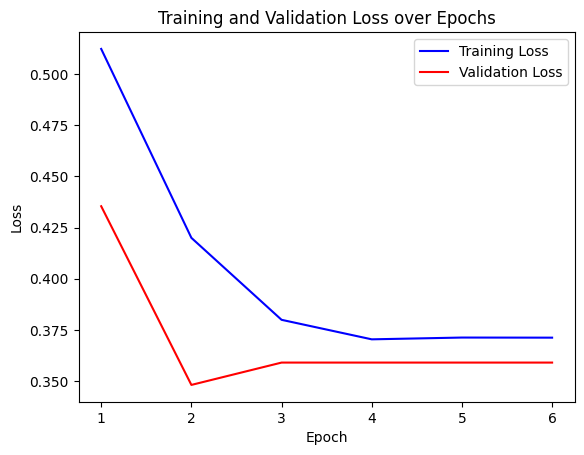

In [ ]:
import matplotlib.pyplot as plt

# loss와 val_loss를 저장할 리스트
losses = [0.51231, 0.41998,  0.37992, 0.37038, 0.37125, 0.37120]
val_losses = [0.43543, 0.34810, 0.35902, 0.35902, 0.35902, 0.35902]

plt.plot(range(1, len(losses) + 1), losses, color='blue',label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
# 모델과 옵티마이저 초기화
gender_model = Gender_Net().to(device)
opt_age = optim.Adam(gender_model.parameters(), lr=0.0003)

# 체크포인트 불러오기
age_model, opt_age, start_epoch = load_model(gender_model, opt_age, '/content/drive/MyDrive/models/gender_model_checkpoint.pth')

# 학습 재개
start = time.time()
for epoch in range(start_epoch + 1, start_epoch + 28):
    gender_loss = train_loop_gender(train_loader, gender_model, nn.BCEWithLogitsLoss(), opt_gender, epoch)
    val_loss = validation_loop_gender(val_loader, gender_model, nn.BCEWithLogitsLoss(), device)
    gender_lr_scheduler.step(val_loss)
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_checkpoint.pth')
        break

    save_model(epoch, gender_model, opt_gender, f'/content/drive/MyDrive/models/gender_model_checkpoint_epoch_{epoch+1}.pth')
    print(f'Epoch : {epoch+1}, Loss : {gender_loss}, Val_loss : {val_loss}')

total_time = time.time() - start
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))